In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.simplefilter("ignore", category=UserWarning)

import os
os.environ['OMP_NUM_THREADS'] = '1'


In [33]:

from modules.data_loader import load_and_engineer_features, build_preprocessor
from modules.model_utils import build_pipeline
from modules.evaluation import evaluate_model


# Classification

### XGBoost


In [34]:
import pandas as pd
import numpy as np


from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Load and prepare data 
df = load_and_engineer_features("updated_dataset (1).csv")
features = ['Age', 'Gender', 'Race', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']
categorical = ['Gender', 'Race']
numerical = ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']

X = df[features]
y = df['Hospital_LOS_Category'].astype(int)

preprocessor = build_preprocessor(numerical, categorical)

# XGBoost setup 
XGB_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

pipeline = build_pipeline(preprocessor, XGB_model)

param_grid = {
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.001, 0.01, 0.1, 0.3],  
    'model__max_depth': [3, 5, 7, 10],  
    'model__gamma': [0, 0.1, 0.2, 0.3],  
    'model__subsample': [0.6, 1.0],  
    'model__reg_alpha': [0, 0.01, 0.1, 1],  
    'model__reg_lambda': [0.1, 1, 10]  
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# Evaluate 
XGB_y_pred = grid_search.predict(X)
XGB_y_prob = grid_search.predict_proba(X)[:, 1]
evaluate_model(y, XGB_y_pred, XGB_y_prob)

import pickle
import os

# Save best model 
os.makedirs("saved_models", exist_ok=True)
with open("saved_models/xgb_model.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)



Fitting 5 folds for each of 6144 candidates, totalling 30720 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.77      0.66        64
           1       0.92      0.82      0.87       199

    accuracy                           0.81       263
   macro avg       0.75      0.79      0.76       263
weighted avg       0.84      0.81      0.82       263

Confusion Matrix:
[[ 49  15]
 [ 35 164]]
AUC Score: 0.8894
F1 Score: 0.8177
Accuracy: 0.8099


### SVM

In [35]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

from modules.data_loader import load_and_engineer_features, build_preprocessor
from modules.model_utils import build_pipeline
from modules.evaluation import evaluate_model

# Load Data
df = load_and_engineer_features("updated_dataset (1).csv")
features = ['Age', 'Gender', 'Race', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']
categorical = ['Gender', 'Race']
numerical = ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']

X = df[features]
y = df['Hospital_LOS_Category'].astype(int)


preprocessor = build_preprocessor(numerical, categorical)

#  SVM Setup 
svm_model = SVC(probability=True, random_state=42)

pipeline = build_pipeline(preprocessor, svm_model)


param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto', 0.01, 0.001],
    'model__class_weight': [None, 'balanced']
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# Evaluate
print(f"Best Parameters: {grid_search.best_params_}")
SVM_y_pred = grid_search.predict(X)
SVM_y_prob = grid_search.predict_proba(X)[:, 1]

evaluate_model(y, SVM_y_pred, SVM_y_prob)
import pickle
import os

# Save best model
os.makedirs("saved_models", exist_ok=True)
with open("saved_models/svm_model.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.73      0.52        64
           1       0.88      0.65      0.75       199

    accuracy                           0.67       263
   macro avg       0.64      0.69      0.64       263
weighted avg       0.77      0.67      0.70       263

Confusion Matrix:
[[ 47  17]
 [ 69 130]]
AUC Score: 0.7680
F1 Score: 0.6957
Accuracy: 0.6730


### ANN

In [36]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from modules.data_loader import load_and_engineer_features, build_preprocessor
from modules.evaluation import evaluate_model

# Load and prepare data
df = load_and_engineer_features("updated_dataset (1).csv")
features = ['Age', 'Gender', 'Race', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']
categorical = ['Gender', 'Race']
numerical = ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']

X = df[features]
y = df['Hospital_LOS_Category'].astype(int)

preprocessor = build_preprocessor(numerical, categorical)
X = preprocessor.fit_transform(X)

# ANN
def create_ann_model(hidden_units=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap with KerasClassifier 
ann_model = KerasClassifier(
    model=create_ann_model,
    verbose=0,
    random_state=42
)

param_grid = {
    'model__hidden_units': [32, 64, 128],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=ann_model, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X, y)

# Evaluate
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
ANN_y_prob = best_model.predict_proba(X)[:, 1]
ANN_y_pred = (ANN_y_prob > 0.5).astype(int)

evaluate_model(y, ANN_y_pred, ANN_y_prob)

import pickle
import os

# Save best model
os.makedirs("saved_models", exist_ok=True)
with open("saved_models/ann_model.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.4, 'model__hidden_units': 64, 'model__learning_rate': 0.001}
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.36      0.49        64
           1       0.82      0.96      0.89       199

    accuracy                           0.82       263
   macro avg       0.80      0.66      0.69       263
weighted avg       0.81      0.82      0.79       263

Confusion Matrix:
[[ 23  41]
 [  7 192]]
AUC Score: 0.8655
F1 Score: 0.7917
Accuracy: 0.8175


In [37]:
# from joblib import dump

# # pipeline = build_pipeline(preprocessor, model)
# dump(pipeline, "saved_models/ann_model_with_pipeline.pkl")


In [38]:
# from tensorflow.keras.utils import plot_model

# Visualize the ANN Model
# def visualize_ann_model(model):
#    plot_model(
#        model,
#        to_file="ann_model.png",  # Saves the model visualization as a file
#        show_shapes=True,         # Displays the shapes of layers
#        show_layer_names=True     # Shows layer names
#    )
#    print("ANN model visualization saved as ann_model.png")


# visualize_ann_model(create_ann_model())


## Diversity

In [39]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import pearsonr
from modules.diversity import calculate_diversity, calculate_bias_variance_with_risk, bootstrap_sample

models = {
    'XGBoost': XGB_model,
    'SVM': svm_model,
    'ANN': ann_model 
}

# Bias-Variance Analysis
bias_variance_results = calculate_bias_variance_with_risk(models, X, y)
print("Bias-Variance Results:")
print(bias_variance_results)

# Diversity Analysis
diversity_results = calculate_diversity(models, X, y)
print("Diversity Results:")
print(diversity_results)


Bias-Variance Results:
{'XGBoost': {'bias': 0.041216730038022814, 'variance': 0.06144486692015211, 'diversity': 0.1723222831037025, 'expected_risk': -0.06966068614552759}, 'SVM': {'bias': 0.15863117870722435, 'variance': 0.05353612167300381, 'diversity': 0.09929072272260696, 'expected_risk': 0.1128765776576212}, 'ANN': {'bias': 0.2705703422053232, 'variance': 0.02524714828897339, 'diversity': 0.107443507929853, 'expected_risk': 0.18837398256444363}}
Diversity Results:
{'XGBoost vs SVM': {'disagreement': 0.1634980988593156, 'correlation': 0.4523146025245371, 'q_statistic': 0.6920152091254753}, 'XGBoost vs ANN': {'disagreement': 0.26996197718631176, 'correlation': 0.0315939468319055, 'q_statistic': 0.6007604562737643}, 'SVM vs ANN': {'disagreement': 0.1596958174904943, 'correlation': 0.03901195912674422, 'q_statistic': 0.5057034220532319}}


In [40]:
from modules.ensemble import weighted_average_ensemble, snapshot_dropout_ensemble, snapshot_predict
import numpy as np


# XGBoost + ANN Weighted Ensemble
weights = [0.6, 0.4]
models = [XGB_model, ann_model]
ensemble_probs = weighted_average_ensemble(models, weights, X)
ensemble_preds = (ensemble_probs > 0.5).astype(int)

# Evaluate
print("Weighted Averaging Ensemble:")
evaluate_model(y, ensemble_preds, ensemble_probs)


Weighted Averaging Ensemble:
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        64
           1       0.92      0.94      0.93       199

    accuracy                           0.89       263
   macro avg       0.86      0.84      0.85       263
weighted avg       0.89      0.89      0.89       263

Confusion Matrix:
[[ 47  17]
 [ 11 188]]
AUC Score: 0.8739
F1 Score: 0.8917
Accuracy: 0.8935


In [53]:
from modules.ensemble_utils import WeightedAverageEnsemble
import pickle

xgb_ann = WeightedAverageEnsemble(models=[XGB_model, ann_model], weights=[0.6, 0.4])

with open("saved_models/XGB+ANN_ensemble_model_weighted.pkl", "wb") as f:
    pickle.dump(xgb_ann, f)


In [52]:
# XGBoost + ANN + SVM Ensemble
weights = [0.5, 0.3, 0.2]  # Adjusted for XGBoost, ANN, and SVM
models = [XGB_model, ann_model, svm_model]
weighted_probs = weighted_average_ensemble(models, weights, X)
weighted_preds = (weighted_probs > 0.5).astype(int)

from modules.ensemble_utils import WeightedAverageEnsemble
import pickle



print("Weighted Averaging Ensemble with SVM:")
evaluate_model(y, weighted_preds, weighted_probs)


xgb_ann_svm = WeightedAverageEnsemble(models=[XGB_model, ann_model, svm_model], weights=[0.5, 0.3, 0.2])

with open("saved_models/XGB_ANN_SVM_ensemble_model_weighted.pkl", "wb") as f:
    pickle.dump(xgb_ann_svm, f)



Weighted Averaging Ensemble with SVM:
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        64
           1       0.92      0.95      0.94       199

    accuracy                           0.90       263
   macro avg       0.88      0.84      0.86       263
weighted avg       0.90      0.90      0.90       263

Confusion Matrix:
[[ 47  17]
 [  9 190]]
AUC Score: 0.8586
F1 Score: 0.8988
Accuracy: 0.9011


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix
import numpy as np

# Snapshot Ensembles for ANN
snapshots_ann = snapshot_dropout_ensemble(ann_model, X, y, n_snapshots=50, dropout_rate=0.5)

snapshot_probs = snapshot_predict(snapshots_ann, X)  # Directly get probabilities from snapshot ensemble

xgb_probs = XGB_model.predict_proba(X)[:, 1]  # Get probabilities for the positive class from XGBoost

# XGBoost + Snapshot ANN Ensemble
weights = [0.6, 0.4]  
snapshot_ensemble_probs = np.average([xgb_probs, snapshot_probs], axis=0, weights=weights)

snapshot_ensemble_preds = (snapshot_ensemble_probs > 0.5).astype(int)

evaluate_model(y, snapshot_ensemble_preds, snapshot_ensemble_probs)

from modules.ensemble_utils import SnapshotANNEnsemble
import pickle

snapshot_model = SnapshotANNEnsemble(base_model=ann_model, n_snapshots=50, dropout_rate=0.5)
snapshot_model.fit(X, y)

# Save to disk
with open("saved_models/snapshot_ensemble_model.pkl", "wb") as f:
    pickle.dump(snapshot_model, f)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.66      0.76        64
           1       0.90      0.98      0.94       199

    accuracy                           0.90       263
   macro avg       0.91      0.82      0.85       263
weighted avg       0.90      0.90      0.90       263

Confusion Matrix:
[[ 42  22]
 [  4 195]]
AUC Score: 0.8721
F1 Score: 0.8952
Accuracy: 0.9011


In [55]:
import importlib
import modules.ensemble_utils
importlib.reload(modules.ensemble_utils)
from modules.ensemble_utils import SnapshotANNEnsemble



snapshot_model = SnapshotANNEnsemble(base_model=ann_model, n_snapshots=50, dropout_rate=0.5)
snapshot_model.fit(X, y)

# Save to disk
with open("saved_models/snapshot_ensemble_model.pkl", "wb") as f:
    pickle.dump(snapshot_model, f)


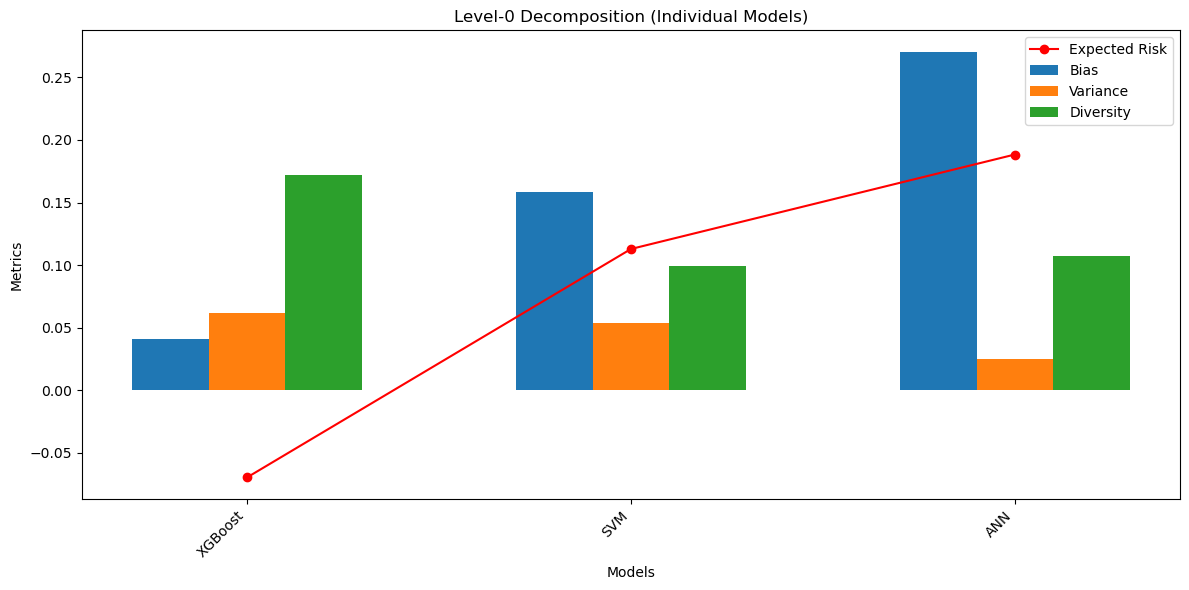

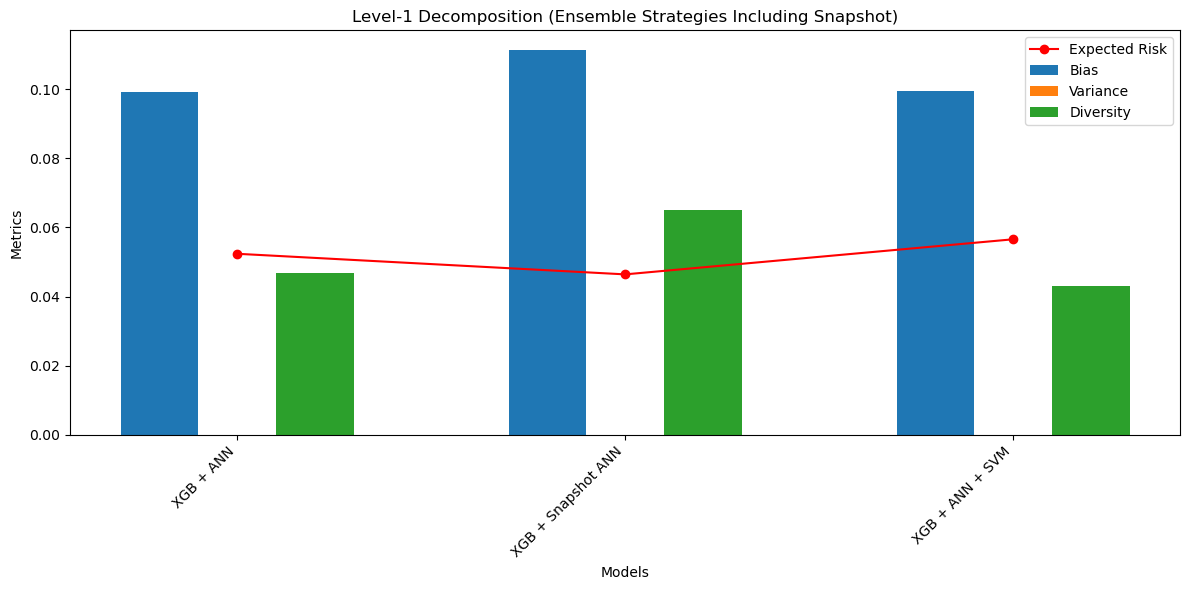

In [43]:
from modules.diversity import calculate_diversity, calculate_bias_variance_with_risk, bootstrap_sample, plot_decomposition, calculate_decomposition


# Level-0 Models (Individual Models)
models_level_0 = {
    'XGBoost': XGB_model,
    'SVM': svm_model,
    'ANN': ann_model
}

# Level-1 Ensembles (Ensemble Strategies)
models_level_1 = {
    'XGB + ANN': np.average(
        [XGB_model.predict_proba(X)[:, 1], ann_model.predict_proba(X)[:, 1]], axis=0, weights=[0.6, 0.4]
    ),
    'XGB + Snapshot ANN': np.average(
        [XGB_model.predict_proba(X)[:, 1], snapshot_probs], axis=0, weights=[0.6, 0.4]
    ),
    'XGB + ANN + SVM': np.average(
        [XGB_model.predict_proba(X)[:, 1], ann_model.predict_proba(X)[:, 1], svm_model.predict_proba(X)[:, 1]],
        axis=0,
        weights=[0.5, 0.3, 0.2]
    )
}

# Level-0 Analysis
level_0_results = calculate_decomposition(models_level_0, X, y)
plot_decomposition(level_0_results, "Level-0 Decomposition (Individual Models)")

# Level-1 Analysis
level_1_results = calculate_decomposition(models_level_1, X, y)
plot_decomposition(level_1_results, "Level-1 Decomposition (Ensemble Strategies Including Snapshot)")



📈 Friedman Test: Statistic=15.0980, P-value=0.0100

📊 Conover Post-Hoc Test Results:
                  XGBoost       SVM       ANN  XGB + ANN  XGB + ANN + SVM  Snapshot ANN
XGBoost          1.000000  0.014203  0.117303   0.548456         0.235095      0.235095
SVM              0.014203  1.000000  0.320351   0.003332         0.000722      0.000722
ANN              0.117303  0.320351  1.000000   0.034921         0.008861      0.008861
XGB + ANN        0.548456  0.003332  0.034921   1.000000         0.548456      0.548456
XGB + ANN + SVM  0.235095  0.000722  0.008861   0.548456         1.000000      1.000000
Snapshot ANN     0.235095  0.000722  0.008861   0.548456         1.000000      1.000000


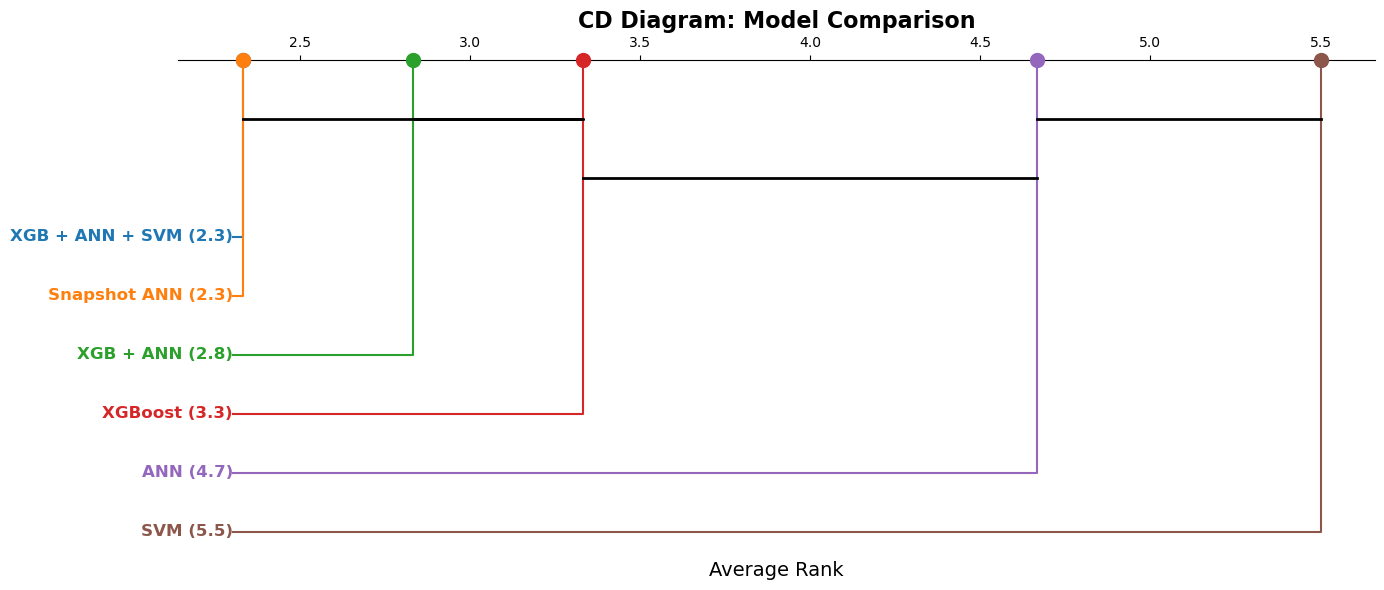

In [44]:
from modules.evaluation import evaluate_model, evaluate_all_metrics, plot_cd_diagram

# Model probs and preds
level_0_probs = {
    'XGBoost': XGB_y_prob,
    'SVM': SVM_y_prob,
    'ANN': ANN_y_prob,
}

level_1_probs = {
    'XGB + ANN': ensemble_probs,
    'XGB + ANN + SVM': weighted_probs,
    'Snapshot ANN': snapshot_ensemble_probs
}

# Evaluate
df_scores, df_ranks, avg_ranks, posthoc = evaluate_all_metrics(y, {**level_0_probs, **level_1_probs})
plot_cd_diagram(avg_ranks, posthoc, "CD Diagram: Model Comparison")


In [45]:
posthoc

,XGBoost,SVM,ANN,XGB + ANN,XGB + ANN + SVM,Snapshot ANN
XGBoost,1.000000,0.014203,0.117303,0.548456,0.235095,0.235095
SVM,0.014203,1.000000,0.320351,0.003332,0.000722,0.000722
ANN,0.117303,0.320351,1.000000,0.034921,0.008861,0.008861
XGB + ANN,0.548456,0.003332,0.034921,1.000000,0.548456,0.548456
XGB + ANN + SVM,0.235095,0.000722,0.008861,0.548456,1.000000,1.000000
Snapshot ANN,0.235095,0.000722,0.008861,0.548456,1.000000,1.000000


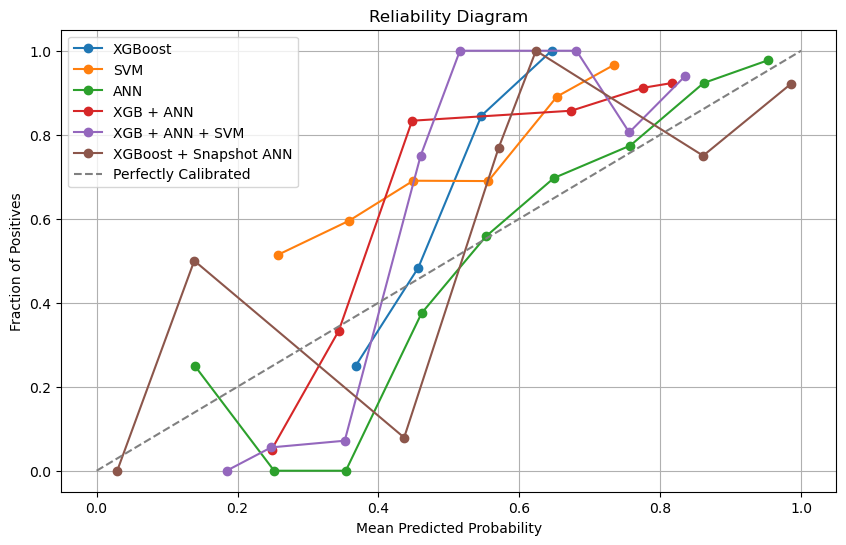

In [46]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Reliability Diagram for Ensembles
def plot_reliability_diagram(y_true, model_probs, model_labels):
    plt.figure(figsize=(10, 6))
    for probs, label in zip(model_probs, model_labels):
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true, probs, n_bins=10, strategy='uniform')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=label)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid()
    plt.show()


model_probs = [XGB_y_prob, SVM_y_prob, ANN_y_prob, ensemble_probs, weighted_probs, snapshot_ensemble_probs]
model_labels = ['XGBoost', 'SVM', 'ANN', 'XGB + ANN', 'XGB + ANN + SVM', 'XGBoost + Snapshot ANN']
plot_reliability_diagram(y, model_probs, model_labels)


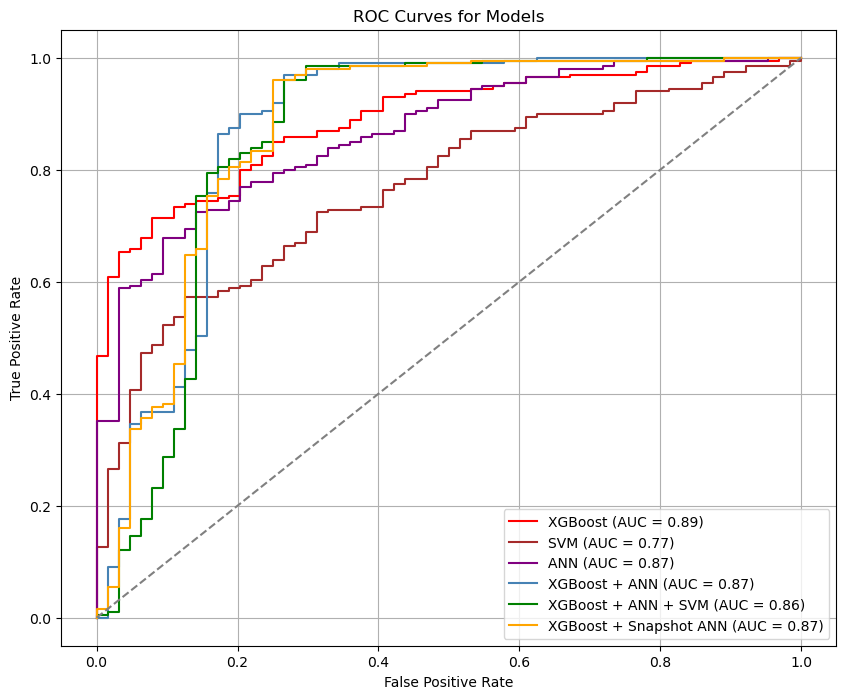

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC curve data
models_data = {
    'XGBoost': XGB_y_prob,
    'SVM': SVM_y_prob,
    'ANN': ANN_y_prob,
    'XGBoost + ANN': ensemble_probs,
    'XGBoost + ANN + SVM': weighted_probs,
    'XGBoost + Snapshot ANN': snapshot_ensemble_probs
}

# Plot
colors = {
    'XGBoost': 'red',
    'SVM': 'brown',
    'ANN': 'purple',
    'XGBoost + ANN': '#4682B4',  
    'XGBoost + ANN + SVM': 'green',
    'XGBoost + Snapshot ANN': '#FFA500'  
}

roc_curves = {}

for model_name, y_prob in models_data.items():
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }

plt.figure(figsize=(10, 8))
for model_name, data in roc_curves.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{model_name} (AUC = {data['auc']:.2f})", color=colors[model_name])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('ROC Curves for Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [48]:
from sklearn.metrics import confusion_matrix

# Sensitivity and Specificity Analysis
models_predictions = {
    'XGBoost': XGB_y_pred,
    'SVM': SVM_y_pred,
    'ANN': ANN_y_pred,
    'Weighted Averaging (XGBoost + ANN)': ensemble_preds,
    'Weighted Averaging (XGBoost + ANN + SVM)': weighted_preds,
    'Snapshot': snapshot_ensemble_preds  # Replace with snapshot predictions
}

sensitivity_specificity = {}

for model_name, predictions in models_predictions.items():
    cm = confusion_matrix(y, predictions)  
    TN, FP, FN, TP = cm.ravel()  

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_specificity[model_name] = {
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }

    print(f"Model: {model_name}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}\n")

import pandas as pd

sensitivity_specificity_df = pd.DataFrame(sensitivity_specificity).T
print(sensitivity_specificity_df)


Model: XGBoost
Confusion Matrix:
[[ 49  15]
 [ 35 164]]
Sensitivity: 0.8241
Specificity: 0.7656

Model: SVM
Confusion Matrix:
[[ 47  17]
 [ 69 130]]
Sensitivity: 0.6533
Specificity: 0.7344

Model: ANN
Confusion Matrix:
[[ 23  41]
 [  7 192]]
Sensitivity: 0.9648
Specificity: 0.3594

Model: Weighted Averaging (XGBoost + ANN)
Confusion Matrix:
[[ 47  17]
 [ 11 188]]
Sensitivity: 0.9447
Specificity: 0.7344

Model: Weighted Averaging (XGBoost + ANN + SVM)
Confusion Matrix:
[[ 47  17]
 [  9 190]]
Sensitivity: 0.9548
Specificity: 0.7344

Model: Snapshot
Confusion Matrix:
[[ 42  22]
 [  4 195]]
Sensitivity: 0.9799
Specificity: 0.6562

                                          Sensitivity  Specificity
XGBoost                                      0.824121     0.765625
SVM                                          0.653266     0.734375
ANN                                          0.964824     0.359375
Weighted Averaging (XGBoost + ANN)           0.944724     0.734375
Weighted Averaging (XGBoost + 